# Memento-CXG cross-dataset showcase

In [1]:
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
import itertools
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import scanpy as sc
import statsmodels.api as sm

In [2]:
from statsmodels.stats.multitest import fdrcorrection

In [3]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation/')
import memento

In [4]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

In [100]:
def compare_dcs(all_estimators):
    
    def treatment_assignment(row):

        ct = row['cell_type']
        if 'plasma' in ct:
            return 'pdc'
        if 'conven' in ct or 'myeloid' in ct:
            return 'cdc'
        else:
            return 'unknown'

    all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
    estimators = all_estimators.query('treatment != "unknown"').copy()

    donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
    donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
    estimators = estimators.query('donor_id in @donors_to_use').copy()



    CUBE_TILEDB_DIMS_OBS = [
        "cell_type",
        "dataset_id",
    ]

    CUBE_TILEDB_ATTRS_OBS = [
        "assay",
        "suspension_type",
        "donor_id",
        "disease",
        "sex"
    ]

    CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

    DE_TREATMENT = 'treatment'
    DE_COVARIATES = ['donor_id']
    DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

    names = estimators[DE_TREATMENT].copy()
    for col in DE_COVARIATES:
        names += '_' + estimators[col]
    estimators['group_name'] = names.tolist()

    estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

    features = estimators['feature_id'].drop_duplicates().tolist()

    # This line doesnt do anything for actual run, just for shuffled
    groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

    mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
    se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
    cell_counts = groups['n_obs'].sort_index().values

    # Filter genes for actually expressed ones
    genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
    mean = mean[genes_to_test]
    se_mean = se_mean[genes_to_test]

    # design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

    design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
    design['constant'] = 1
    
    print(len(genes_to_test))

    # meta = 

    def get_final_design_matrix(design):
        cov_df = design.iloc[:, 1:]
        cov_df -= cov_df.mean(axis=0)
        stim_df = design.iloc[:, [0]]
        interaction_df = cov_df*stim_df[['treatment_pdc']].values
        interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
        cov_df = pd.concat([cov_df, interaction_df], axis=1)
        cov_df = sm.add_constant(cov_df)
        return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)


    def wls(X, y, n, v, tau2=0, thresh=1):

        from sklearn.linear_model import LinearRegression

        # fit WLS using sample_weights
        WLS = LinearRegression(fit_intercept=False)
        WLS.fit(X, y, sample_weight=n)
        sample_err = ((WLS.predict(X) - y)**2).mean()

        coef = WLS.coef_[0]

        W = np.diag(1/ (v+tau2) )
        beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
        se = np.sqrt( beta_var_hat[0] )

        z = coef/se
        pv = stats.norm.sf(np.abs(z))

        return coef, z, pv

    # def resample_donors(X, y, n, v):

    from sklearn.linear_model import LinearRegression

    # %%time
    de_result = []
    for feature in genes_to_test[:2000]: # Can be vectorized heavily, showing for 1K genes

        m = mean[feature].values
        sem = se_mean[feature].values

        # Transform to log space (alternatively can resample in log space)
        lm = np.log(m)
        selm = (np.log(m+sem)-np.log(m-sem))/2

        sample_idxs = np.isfinite(m) & np.isfinite(sem)

        sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]

        donors_to_use_ = sample_design.groupby('donor_id').size()
        donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()

        final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values

        # final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)


        X, y, n, v = (
            get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
            lm[sample_idxs][final_sample_idxs], 
            cell_counts[sample_idxs][final_sample_idxs], 
            selm[sample_idxs][final_sample_idxs]**2)
        
        
        if X.shape[0] != X.shape[1]:
            continue

        coef, z, pv = wls(X, y, n, v)

        de_result.append((feature, coef, z, pv))

    de_result_wls = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
    
    return de_result_wls

### Grab cell counts

In [317]:
import concurrent
import gc
import logging
import multiprocessing
import os
import sys
from concurrent import futures
import time

import numpy as np
import pandas as pd
import pyarrow as pa
import scipy.sparse
import scipy.sparse
import tiledb
import tiledbsoma as soma
from somacore import ExperimentAxisQuery, AxisQuery
from tiledb import ZstdFilter, ArraySchema, Domain, Dim, Attr, FilterList

In [323]:
dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']
dataset_query = '('
for idx, di in enumerate(dataset_ids_to_query): 
    dataset_query += f'dataset_id == "{di}" '
    if idx != len(dataset_ids_to_query)-1:
        dataset_query += 'or '
dataset_query += ')'

celltypes_to_query = [
    'conventional dendritic cell',
    'plasmacytoid dendritic cell',
    'conventional dendritic cell',
    'plasmacytoid dendritic cell, human',
    'dendritic cell',
    'dendritic cell, human',
    'myeloid dendritic cell',
    'plasmacytoid dendritic cell']
celltype_query = '('
for idx, ct in enumerate(celltypes_to_query): 
    celltype_query += f'cell_type == "{ct}" '
    if idx != len(celltypes_to_query)-1:
        celltype_query += 'or '
celltype_query += ')'

OBS_VALUE_FILTER_1 = dataset_query # All cells in three datasets
OBS_VALUE_FILTER_2 = celltype_query + ' and ' + celltype_query # only relevant celltypes

In [329]:
# init multiprocessing
start = time.time()
if multiprocessing.get_start_method(True) != "spawn":
    multiprocessing.set_start_method("spawn", True)

exp_uri = 's3://cellxgene-data-public/cell-census/2023-10-30/soma/census_data/homo_sapiens'
layer = "raw"
measurement_name = "RNA"

with soma.Experiment.open(uri=exp_uri,
                          context=soma.SOMATileDBContext().replace(tiledb_config={
                              "vfs.s3.region":"us-west-2",
                              "vfs.s3.no_sign_request":True})
                          ) as exp:

    query = exp.axis_query(measurement_name=measurement_name,
                           obs_query=AxisQuery(value_filter=OBS_VALUE_FILTER_2),
                           # Note: Must use *all* genes to compute size factors correctly, even when var filter is
                           # being used for testing
                           var_query=AxisQuery())

In [330]:
TEST_MODE = bool(os.getenv("TEST_MODE", False))  # Read data from simple test fixture Census data
PROFILE_MODE = bool(os.getenv("PROFILE_MODE", False))  # Run pass 2 in single-process mode with profiling output

ESTIMATORS_CUBE_ARRAY_URI = "estimators_cube"

OBS_WITH_SIZE_FACTOR_TILEDB_ARRAY_URI = "obs_with_size_factor"

TILEDB_SOMA_BUFFER_BYTES = 2**31
if TEST_MODE:
    TILEDB_SOMA_BUFFER_BYTES = 10 * 1024 ** 2

# The minimum number of cells that should be processed at a time by each child process.
MIN_BATCH_SIZE = 2**14
# For testing
MIN_BATCH_SIZE = 20000

CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

if TEST_MODE:
    CUBE_TILEDB_DIMS_OBS = ["celltype"]
    CUBE_TILEDB_ATTRS_OBS = ["study"]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

CUBE_DIMS_VAR = ['feature_id']

if TEST_MODE:
    CUBE_DIMS_VAR = ['var_id']

CUBE_TILEDB_DIMS = CUBE_DIMS_VAR + CUBE_TILEDB_DIMS_OBS

ESTIMATOR_NAMES = ['nnz', 'n_obs', 'min', 'max', 'sum', 'mean', 'sem', 'var', 'sev', 'selv']


CUBE_SCHEMA = ArraySchema(
  domain=Domain(*[
    Dim(name=dim_name, dtype="ascii", filters=FilterList([ZstdFilter(level=-1), ]))
    for dim_name in CUBE_TILEDB_DIMS
  ]),
  attrs=[Attr(name=attr_name, dtype='ascii', nullable=False, filters=FilterList([ZstdFilter(level=-1), ]))
         for attr_name in CUBE_TILEDB_ATTRS_OBS] +
        [Attr(name=estimator_name, dtype='float64', var=False, nullable=False, filters=FilterList([ZstdFilter(level=-1), ]))
         for estimator_name in ESTIMATOR_NAMES],
  cell_order='row-major',
  tile_order='row-major',
  capacity=10000,
  sparse=True,
  allows_duplicates=True,
)


In [331]:
obs_df = query.obs().concat().to_pandas()

In [332]:
obs_df.head(5)

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,donor_id,is_primary_data,self_reported_ethnicity,self_reported_ethnicity_ontology_term_id,sex,sex_ontology_term_id,suspension_type,tissue,tissue_ontology_term_id,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars
0,3106324,cf83c98a-3791-4537-bbde-a719f6d73c13,10x 3' v3,EFO:0009922,conventional dendritic cell,CL:0000990,8-month-old human stage,HsapDv:0000181,B-cell acute lymphoblastic leukemia,MONDO:0004947,HTA4_13,True,unknown,unknown,female,PATO:0000383,cell,blood,UBERON:0000178,blood,UBERON:0000178,20110.0,4247,4.735107,247.068534,20086
1,3106423,cf83c98a-3791-4537-bbde-a719f6d73c13,10x 3' v3,EFO:0009922,plasmacytoid dendritic cell,CL:0000784,8-month-old human stage,HsapDv:0000181,B-cell acute lymphoblastic leukemia,MONDO:0004947,HTA4_13,True,unknown,unknown,female,PATO:0000383,cell,blood,UBERON:0000178,blood,UBERON:0000178,1738.0,1098,1.582878,8.369151,20086
2,3106607,cf83c98a-3791-4537-bbde-a719f6d73c13,10x 3' v3,EFO:0009922,conventional dendritic cell,CL:0000990,8-month-old human stage,HsapDv:0000181,B-cell acute lymphoblastic leukemia,MONDO:0004947,HTA4_13,True,unknown,unknown,female,PATO:0000383,cell,blood,UBERON:0000178,blood,UBERON:0000178,14675.0,3535,4.151344,260.026042,20086
3,3106734,cf83c98a-3791-4537-bbde-a719f6d73c13,10x 3' v3,EFO:0009922,plasmacytoid dendritic cell,CL:0000784,8-month-old human stage,HsapDv:0000181,B-cell acute lymphoblastic leukemia,MONDO:0004947,HTA4_13,True,unknown,unknown,female,PATO:0000383,cell,blood,UBERON:0000178,blood,UBERON:0000178,2325.0,1277,1.820673,23.631610,20086
4,3106822,cf83c98a-3791-4537-bbde-a719f6d73c13,10x 3' v3,EFO:0009922,plasmacytoid dendritic cell,CL:0000784,8-month-old human stage,HsapDv:0000181,B-cell acute lymphoblastic leukemia,MONDO:0004947,HTA4_13,True,unknown,unknown,female,PATO:0000383,cell,blood,UBERON:0000178,blood,UBERON:0000178,11807.0,3265,3.616233,134.786807,20086


In [334]:
donor_counts = dict(obs_df.groupby('donor_id').size())

### Using 3 datasets

In [43]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

In [44]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_dcs').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})


KeyboardInterrupt



In [ ]:
three_dataset_result = compare_dcs(all_estimators)

In [ ]:
three_dataset_result.to_csv(save_path + 'three_datasets.csv')

### Using 1 datasets

In [45]:
dataset_ids_to_query = ['c7775e88-49bf-4ba2-a03b-93f00447c958', '218acb0f-9f2f-4f76-b90b-15a4b7c7f629', '4c4cd77c-8fee-4836-9145-16562a8782fe']


In [46]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_dcs').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [85]:
for dataset in dataset_ids_to_query:
    
    dataset_estimators = all_estimators.query(f'dataset_id == "{dataset}"')
    
    dataset_result = compare_dcs(dataset_estimators)
    break
    
    dataset_result.to_csv(save_path + f'{dataset}.csv')

/tmp/ipykernel_148012/2221661723.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)


9513


In [642]:
filtered=dataset_result.query('coef > 1 | coef < -1')

In [643]:
pv = filtered['pval'].values
pv = np.sort(pv)

In [644]:
ref = np.linspace(0, 1, pv.shape[0])

/tmp/ipykernel_148012/1097348824.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(ref), -np.log10(pv))


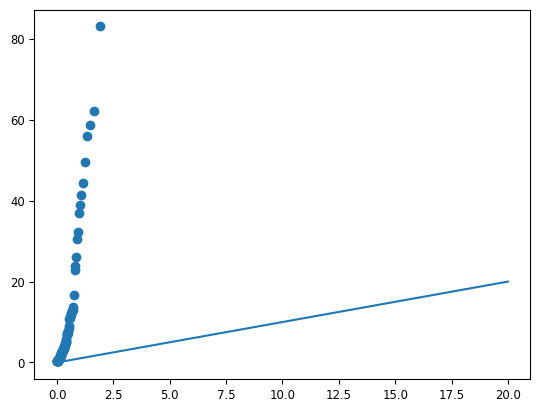

In [645]:
plt.scatter(-np.log10(ref), -np.log10(pv))
plt.plot([0, 20], [0, 20])

### Randomly shuffled dataset (not0

In [707]:
all_shuffled_estimators = tiledb.open(cube_path + 'estimators_cube_dcs').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [708]:
# shuffled_dataset_result = compare_dcs(all_shuffled_estimators)

In [748]:
def treatment_assignment(row):

    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

all_shuffled_estimators['treatment'] = all_shuffled_estimators.apply(treatment_assignment, axis=1)
estimators = all_shuffled_estimators.query('treatment != "unknown"').copy()

donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
estimators = estimators.query('donor_id in @donors_to_use').copy()



CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

features = estimators['feature_id'].drop_duplicates().tolist()

# This line doesnt do anything for actual run, just for shuffled
groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

# mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
# se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
# cell_counts = groups['n_obs'].sort_index().values

# # Filter genes for actually expressed ones
# genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
# mean = mean[genes_to_test]
# se_mean = se_mean[genes_to_test]

# # design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
# design['constant'] = 1

In [749]:
# problematic '1031' '1022',
# good '1004', '1014' '1015', '1019', '1039'

In [750]:
donor_to_check = [
    '1004',
 '1014',
 '1015',
 '1019',
    
    
    
#  '1022',
#  '1031',
    
    
    
#  '1039',
#  '1045',
#  '1046',
#  '1051',
#  '1054',
#  '1056',
#  '1063',
]
one_donor_estimators = estimators.query(f'donor_id in @donor_to_check')

groups = one_donor_estimators.drop_duplicates(subset='group_name').set_index('group_name')


In [770]:
mean = one_donor_estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = one_donor_estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.7]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

In [766]:
# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

LFC_THRESHOLD = 1.00


design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
design['constant'] = 1

print(len(genes_to_test))

# meta = 

def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)


def wls(X, y, n, v, tau2=0, thresh=1):

    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y)
    sample_err = ((WLS.predict(X) - y)**2).mean()
    # print(WLS.coef_)

    coef = WLS.coef_[0]

    # W = np.diag(1/ (v) )
    W = 1/v
    beta_var_hat = np.diag(np.linalg.pinv((X.T *W)@X ))
    # print(beta_var_hat)
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2

    return coef, z, pv

# def resample_donors(X, y, n, v):

from sklearn.linear_model import LinearRegression

# %%time
regression_de_result = []
manual_de_result = []

for feature in genes_to_test: # Can be vectorized heavily, showing for 1K genes

    m = mean[feature].values
    sem = se_mean[feature].values

    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]

    donors_to_use_ = sample_design.groupby('donor_id').size()
    donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()

    final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values

    final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)


    X, y, n, v = (
        get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
        lm[sample_idxs][final_sample_idxs], 
        cell_counts[sample_idxs][final_sample_idxs], 
        selm[sample_idxs][final_sample_idxs]**2)

    
    # if X.shape[0] != X.shape[1]:
    #     continue

    coef1, z1, pv1 = wls(X, y, n, v)
    regression_de_result.append((feature, coef1, z1, pv1))
    
    
    te_per_donor = np.zeros(len(donors_to_use_))
    v_per_donor = np.zeros(len(donors_to_use_))
    for idx, d in enumerate(donors_to_use_):
    
        treat_idxs= (sample_design.iloc[final_sample_idxs]['donor_id'].values==d) & (sample_design.iloc[final_sample_idxs]['treatment_pdc'] == True)
        ctrl_idxs = (sample_design.iloc[final_sample_idxs]['donor_id'].values==d) & (sample_design.iloc[final_sample_idxs]['treatment_pdc'] == False)

        te_per_donor[idx] = lm[sample_idxs][final_sample_idxs][treat_idxs ] - lm[sample_idxs][final_sample_idxs][ ctrl_idxs]
        v_per_donor[idx] = selm[sample_idxs][final_sample_idxs][treat_idxs ]**2 + selm[sample_idxs][final_sample_idxs][ ctrl_idxs]**2
    
    counts = np.array([donor_counts[d] for d in donors_to_use_])
    coef = np.average(te_per_donor)
    coef_var = (v_per_donor).sum()/len(donors_to_use_)**2
    se = np.sqrt(coef_var)
    
    if np.abs(coef) < LFC_THRESHOLD:
        z = 0
        pv = 1
    else:
        z = (np.abs(coef)-LFC_THRESHOLD)/se
        pv = stats.norm.sf(np.abs(z))*2

    manual_de_result.append((feature, coef, z, pv))
    
    sep_pv = stats.norm.sf(np.absolute(te_per_donor), scale=np.sqrt(v_per_donor))*2

    
    if not np.isclose(coef, coef1):
        print('breaking')
        break

manual_de_result_wls = pd.DataFrame(manual_de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
regression_de_result_wls = pd.DataFrame(regression_de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')

955


In [767]:
regression_de_result_wls.tail(5)

,coef,z,pval
feature_id,,,
ENSG00000269404,1.768014,4.924759,8.446460e-07
ENSG00000269858,0.718087,1.890611,5.867623e-02
ENSG00000269893,-1.054432,-2.917913,3.523829e-03
ENSG00000270170,-0.055807,-0.164202,8.695721e-01
ENSG00000272211,-0.509595,-1.185894,2.356640e-01


In [768]:
manual_de_result_wls.tail(5)

,coef,z,pval
feature_id,,,
ENSG00000269404,1.768014,4.924759,8.446460e-07
ENSG00000269858,0.718087,1.890611,5.867623e-02
ENSG00000269893,-1.054432,2.917913,3.523829e-03
ENSG00000270170,-0.055807,0.164202,8.695721e-01
ENSG00000272211,-0.509595,1.185894,2.356640e-01


<Axes: xlabel='coef', ylabel='Density'>

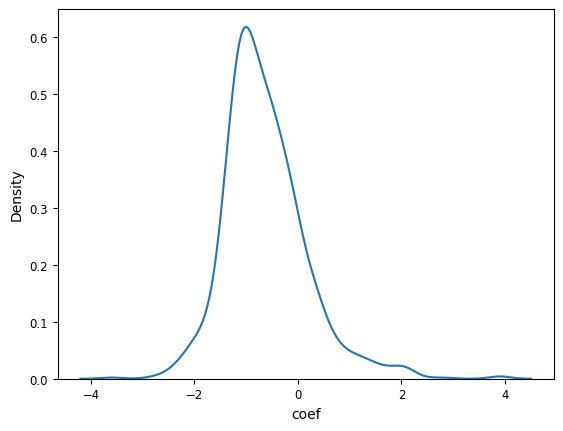

In [769]:
sns.kdeplot(regression_de_result_wls['coef'])

<Axes: >

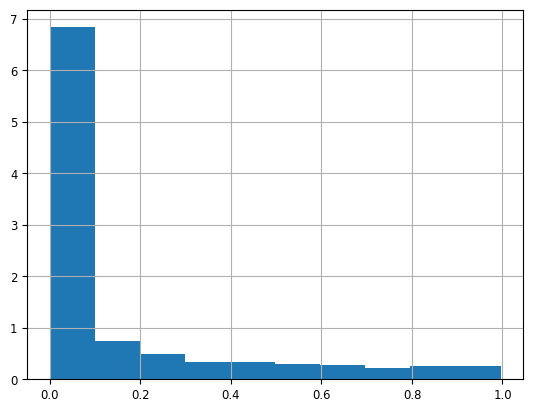

In [762]:
regression_de_result_wls['pval'].hist(bins=10, density=True)

<Axes: >

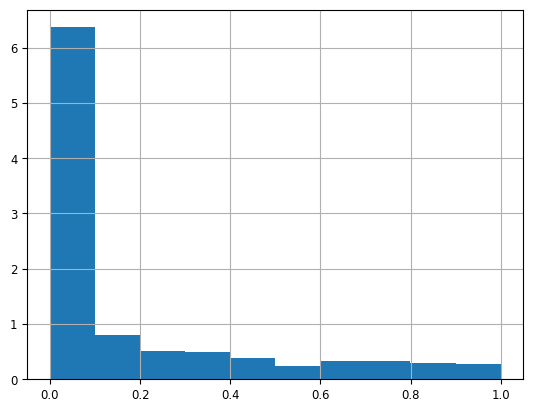

In [733]:
manual_de_result_wls[manual_de_result_wls['coef'].abs() > LFC_THRESHOLD]['pval'].hist(bins=10, density=True)

In [699]:
_, manual_de_result_wls['fdr'] = fdrcorrection(manual_de_result_wls['pval'])

In [701]:
manual_de_result_wls.query('fdr < 0.1').sort_values('fdr')

,coef,z,pval,fdr
feature_id,,,,
ENSG00000132465,4.697930,26.141491,1.231467e-150,2.130437e-147
ENSG00000100453,4.479783,23.919644,1.913270e-126,1.654978e-123
ENSG00000090382,-3.523780,-18.334649,4.378329e-75,2.524836e-72
ENSG00000197747,-2.708885,-17.569689,4.204712e-69,1.818538e-66
ENSG00000135916,3.031391,16.525478,2.405272e-61,8.322240e-59
...,...,...,...,...
ENSG00000168028,-0.255335,-1.885733,5.933096e-02,9.859997e-02
ENSG00000136718,0.350799,1.884951,5.943646e-02,9.868049e-02
ENSG00000085871,-0.280919,-1.883375,5.964951e-02,9.893926e-02


In [110]:
mean

feature_id,ENSG00000000419,ENSG00000000457,ENSG00000000938,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000002587,ENSG00000002822,ENSG00000002834,ENSG00000002919,ENSG00000002933,ENSG00000003056,ENSG00000003147,ENSG00000003400,ENSG00000003402,ENSG00000003509,ENSG00000003756,ENSG00000004059,ENSG00000004142,ENSG00000004399,ENSG00000004455,ENSG00000004468,ENSG00000004478,ENSG00000004487,ENSG00000004534,ENSG00000004700,ENSG00000004766,ENSG00000004779,ENSG00000004799,ENSG00000004864,ENSG00000004866,ENSG00000004897,ENSG00000004961,ENSG00000004975,ENSG00000005007,ENSG00000005020,ENSG00000005022,ENSG00000005059,ENSG00000005075,ENSG00000005100,ENSG00000005156,ENSG00000005175,ENSG00000005194,ENSG00000005238,ENSG00000005249,ENSG00000005302,ENSG00000005339,ENSG00000005379,ENSG00000005436,ENSG00000005448,ENSG00000005469,ENSG00000005483,ENSG00000005486,ENSG00000005700,ENSG00000005801,ENSG00000005810,ENSG00000005812,ENSG00000005844,ENSG00000005882,ENSG00000005889,ENSG00000005893,ENSG00000006007,ENSG00000006015,ENSG00000006025,ENSG00000006125,ENSG00000006194,ENSG00000006282,ENSG00000006327,ENSG00000006451,ENSG00000006459,ENSG00000006530,ENSG00000006534,ENSG00000006576,ENSG00000006607,ENSG00000006625,ENSG00000006634,ENSG00000006652,ENSG00000006695,ENSG00000006712,ENSG00000006715,ENSG00000006744,ENSG00000006756,ENSG00000006757,ENSG00000006831,ENSG00000006837,ENSG00000007047,ENSG00000007080,ENSG00000007129,ENSG00000007168,ENSG00000007202,ENSG00000007237,...,ENSG00000264364,ENSG00000265100,ENSG00000265148,ENSG00000265206,ENSG00000265287,ENSG00000265666,ENSG00000265681,ENSG00000265692,ENSG00000266053,ENSG00000266173,ENSG00000266402,ENSG00000266714,ENSG00000266967,ENSG00000267040,ENSG00000267080,ENSG00000267100,ENSG00000267121,ENSG00000267169,ENSG00000267216,ENSG00000267275,ENSG00000267321,ENSG00000267416,ENSG00000267519,ENSG00000267673,ENSG00000267680,ENSG00000267751,ENSG00000267855,ENSG00000267858,ENSG00000268001,ENSG00000268027,ENSG00000268061,ENSG00000268205,ENSG00000268218,ENSG00000268362,ENSG00000268804,ENSG00000268895,ENSG00000269028,ENSG00000269220,ENSG00000269293,ENSG00000269386,ENSG00000269404,ENSG00000269821,ENSG00000269858,ENSG00000269893,ENSG00000269927,ENSG00000269930,ENSG00000269968,ENSG00000270022,ENSG00000270069,ENSG00000270103,ENSG00000270170,ENSG00000270419,ENSG00000270673,ENSG00000271043,ENSG00000271204,ENSG00000271605,ENSG00000271614,ENSG00000271856,ENSG00000271857,ENSG00000271858,ENSG00000271869,ENSG00000271918,ENSG00000272009,ENSG00000272047,ENSG00000272086,ENSG00000272092,ENSG00000272106,ENSG00000272195,ENSG00000272211,ENSG00000272256,ENSG00000272277,ENSG00000272288,ENSG00000272316,ENSG00000272325,ENSG00000272333,ENSG00000272369,ENSG00000272447,ENSG00000272449,ENSG00000272501,ENSG00000272606,ENSG00000272667,ENSG00000272677,ENSG00000272688,ENSG00000272768,ENSG00000272831,ENSG00000272968,ENSG00000272994,ENSG00000273015,ENSG00000273064,ENSG00000273188,ENSG00000273247,ENSG00000273253,ENSG00000273272,ENSG00000273319,ENSG00000273320,ENSG00000273329,ENSG00000273338,ENSG00000273344,ENSG00000273356,ENSG00000273472
group_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cdc_1004,6.635493e-08,NaN,2.322423e-07,4.976620e-08,NaN,NaN,NaN,3.317747e-08,NaN,4.976620e-08,NaN,NaN,4.976620e-08,1.990648e-07,2.156535e-07,NaN,4.976620e-08,4.976620e-08,NaN,4.976620e-08,1.824761e-07,NaN,1.917648e-07,9.953240e-08,3.317747e-08,4.976620e-08,1.492986e-07,6.635493e-08,3.317747e-08,3.317747e-08,4.794119e-07,3.317747e-08,1.917648e-07,1.161211e-07,6.635493e-08,NaN,1.990648e-07,1.917648e-07,3.317747e-08,NaN,4.976620e-08,4.976620e-08,3.317747e-08,NaN,1.492986e-07,7.299043e-07,2.322423e-07,8.294367e-08,3.317747e-08,NaN,NaN,6.635493e-08,NaN,8.294367e-08,2.6541

<Axes: >

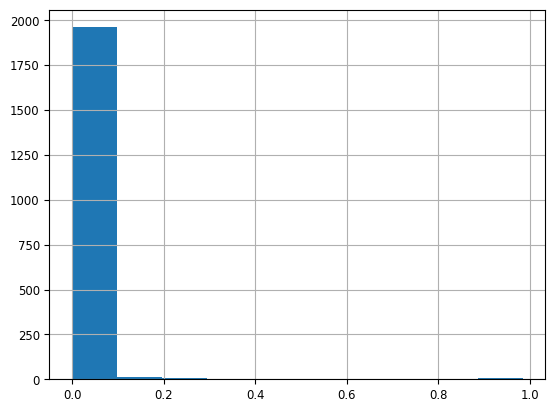

In [106]:
(shuffled_dataset_result['pval']*2).hist()

In [11]:
def treatment_assignment(row):
    
    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
estimators = all_estimators.query('treatment != "unknown"').copy()

donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
estimators = estimators.query('donor_id in @donors_to_use').copy()



CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

features = estimators['feature_id'].drop_duplicates().tolist()

# This line doesnt do anything for actual run, just for shuffled
groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
design['constant'] = 1

# meta = 

def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)
    

def wls(X, y, n, v, tau2=0):
    
    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y, sample_weight=n)
    sample_err = ((WLS.predict(X) - y)**2).mean()

    coef = WLS.coef_[0]

    W = np.diag(1/ (v+tau2) )
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    
    return coef, z, pv

# def resample_donors(X, y, n, v):

from sklearn.linear_model import LinearRegression

# %%time
de_result = []
for feature in genes_to_test[:2000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)
    
    sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]
    
    donors_to_use_ = sample_design.groupby('donor_id').size()
    donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()
    
    final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values
    
    # final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)
    

    X, y, n, v = (
        get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
        lm[sample_idxs][final_sample_idxs], 
        cell_counts[sample_idxs][final_sample_idxs], 
        selm[sample_idxs][final_sample_idxs]**2)
    assert X.shape[0] == X.shape[1]

    coef, z, pv = wls(X, y, n, v)
    
    de_result.append((feature, coef, z, pv))

de_result_wls = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
de_result_wls.to_csv(save_path + 'three_datasets.csv')


KeyboardInterrupt



In [ ]:
_, de_result_wls['fdr'] = fdrcorrection(de_result_wls['pval'])

<Axes: >

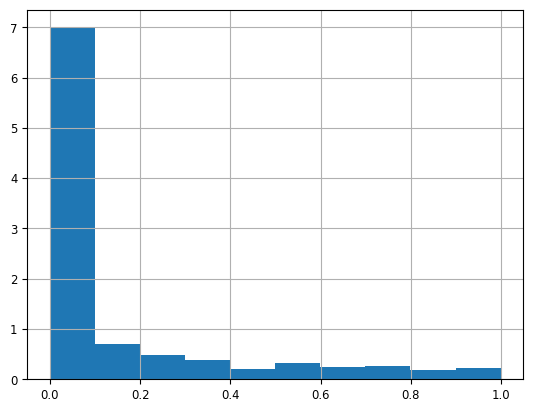

In [50]:
de_result_wls['pval'].hist(density=True)

### Using 3 datasets

In [7]:
cube_path = '/home/ubuntu/Github/memento-cxg/'
save_path = '/home/ubuntu/results/'

In [33]:
all_estimators = tiledb.open(cube_path + 'estimators_cube_2').df[:]\
    .rename(columns={
    'feature_id':'cell_type',
    'cell_type':'dataset_id',
    'dataset_id':'feature_id',
})

In [37]:
def treatment_assignment(row):
    
    ct = row['cell_type']
    if 'plasma' in ct:
        return 'pdc'
    if 'conven' in ct or 'myeloid' in ct:
        return 'cdc'
    else:
        return 'unknown'

In [38]:
all_estimators['treatment'] = all_estimators.apply(treatment_assignment, axis=1)
estimators = all_estimators.query('treatment != "unknown"').copy()

In [36]:
donors_to_use = estimators[['cell_type', 'donor_id']].drop_duplicates().groupby('donor_id').size()
donors_to_use = donors_to_use[donors_to_use > 1].index.tolist()
estimators = estimators.query('donor_id in @donors_to_use').copy()



In [39]:
CUBE_TILEDB_DIMS_OBS = [
    "cell_type",
    "dataset_id",
]

CUBE_TILEDB_ATTRS_OBS = [
    "assay",
    "suspension_type",
    "donor_id",
    "disease",
    "sex"
]

CUBE_LOGICAL_DIMS_OBS = CUBE_TILEDB_DIMS_OBS + CUBE_TILEDB_ATTRS_OBS

DE_TREATMENT = 'treatment'
DE_COVARIATES = ['donor_id']
DE_VARIABLES = [DE_TREATMENT] + DE_COVARIATES

In [40]:
names = estimators[DE_TREATMENT].copy()
for col in DE_COVARIATES:
    names += '_' + estimators[col]
estimators['group_name'] = names.tolist()

estimators = estimators.drop_duplicates(subset=['group_name', 'feature_id'])

In [41]:
features = estimators['feature_id'].drop_duplicates().tolist()

# This line doesnt do anything for actual run, just for shuffled
groups = estimators.drop_duplicates(subset='group_name').set_index('group_name')

In [42]:
mean = estimators.pivot(index='group_name', columns='feature_id', values='mean')
se_mean = estimators.pivot(index='group_name', columns='feature_id', values='sem')
cell_counts = groups['n_obs'].sort_index().values

# Filter genes for actually expressed ones
genes_to_test = mean.columns[mean.isnull().values.mean(axis=0) < 0.6]
mean = mean[genes_to_test]
se_mean = se_mean[genes_to_test]

In [43]:
# design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True).astype(int)

design = pd.get_dummies(groups[DE_VARIABLES], drop_first=True, columns=['treatment'])
design['constant'] = 1

# meta = 

### Run DE

In [44]:
def get_final_design_matrix(design):
    cov_df = design.iloc[:, 1:]
    cov_df -= cov_df.mean(axis=0)
    stim_df = design.iloc[:, [0]]
    interaction_df = cov_df*stim_df[['treatment_pdc']].values
    interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
    cov_df = pd.concat([cov_df, interaction_df], axis=1)
    cov_df = sm.add_constant(cov_df)
    return  pd.concat([stim_df, cov_df], axis=1).values.astype(float)
    

In [45]:
def wls(X, y, n, v, tau2=0):
    
    from sklearn.linear_model import LinearRegression
    
    # fit WLS using sample_weights
    WLS = LinearRegression(fit_intercept=False)
    WLS.fit(X, y, sample_weight=n)
    sample_err = ((WLS.predict(X) - y)**2).mean()

    coef = WLS.coef_[0]

    W = np.diag(1/ (v+tau2) )
    beta_var_hat = np.diag(np.linalg.pinv(X.T@W@X))
    se = np.sqrt( beta_var_hat[0] )

    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    
    return coef, z, pv

In [46]:
# def resample_donors(X, y, n, v):

In [47]:
from sklearn.linear_model import LinearRegression

In [48]:
# %%time
de_result = []
for feature in genes_to_test[:2000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)
    
    sample_design = design[['treatment_pdc', 'donor_id']].iloc[sample_idxs]
    
    donors_to_use_ = sample_design.groupby('donor_id').size()
    donors_to_use_ = donors_to_use_[donors_to_use_ > 1].index.tolist()
    
    final_sample_idxs = sample_design['donor_id'].isin(donors_to_use_).values
    
    # final_sample_idxs = np.ones(final_sample_idxs.shape[0]).astype(bool)
    

    X, y, n, v = (
        get_final_design_matrix(pd.get_dummies(sample_design.iloc[final_sample_idxs], columns=['donor_id'], drop_first=True)), 
        lm[sample_idxs][final_sample_idxs], 
        cell_counts[sample_idxs][final_sample_idxs], 
        selm[sample_idxs][final_sample_idxs]**2)
    assert X.shape[0] == X.shape[1]

    coef, z, pv = wls(X, y, n, v)
    
    de_result.append((feature, coef, z, pv))

de_result_wls = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')
de_result_wls.to_csv(save_path + 'three_datasets.csv')

In [49]:
_, de_result_wls['fdr'] = fdrcorrection(de_result_wls['pval'])

<Axes: >

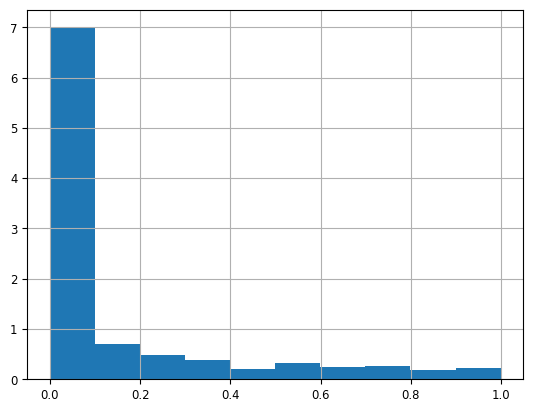

In [50]:
de_result_wls['pval'].hist(density=True)

In [ ]:
%%time
de_result = []
for feature in genes_to_test[:3000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    X, y, n, v = design.iloc[sample_idxs], lm[sample_idxs], cell_counts[sample_idxs], selm[sample_idxs]**2
    info = X.copy()
    info['y'] = y
    info['n'] = n
    info['v'] = v
    info.index = info['donor_id']
    
    donors = info['donor_id'].drop_duplicates().tolist()
    num_donors =len(donors)
    
    num_boot = 1000
    params = np.zeros(num_boot)
    for b in range(num_boot):
        boot_donors = np.random.choice(donors, num_donors, replace=True)
        info_b = info.loc[list(boot_donors)]
        info_b['y_b'] = stats.norm.rvs(info_b['y'], np.sqrt(info_b['v']))
        params[b] = LinearRegression(fit_intercept=False).fit(info_b[['treatment_pdc', 'constant']], info_b['y_b'], sample_weight=info_b['n']).coef_[0]
    
    coef = params.mean()
    se = params.std()
    z = coef/se
    pv = stats.norm.sf(np.abs(z))*2
    # coef, z, pv = de_wls(2)
    
    de_result.append((feature, coef, z, pv))
    
de_result_resampled = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')

In [25]:
de_result_resampled.shape

(2559, 3)

<Axes: >

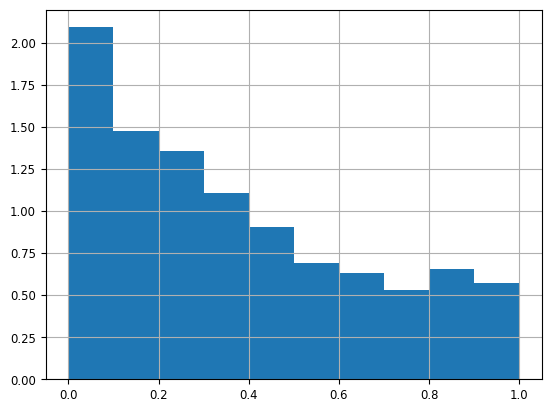

In [89]:
de_result_resampled['pval'].hist(density=True)

In [ ]:
%%time
de_result = []
for feature in genes_to_test[:1000]: # Can be vectorized heavily, showing for 1K genes
    
    m = mean[feature].values
    sem = se_mean[feature].values
    
    # Transform to log space (alternatively can resample in log space)
    lm = np.log(m)
    selm = (np.log(m+sem)-np.log(m-sem))/2

    sample_idxs = np.isfinite(m) & np.isfinite(sem)

    X, y, n, v = design.iloc[sample_idxs], lm[sample_idxs], cell_counts[sample_idxs], selm[sample_idxs]**2
    
    
    
    
    # coef, z, pv = de_wls(2)
    
    de_result.append((feature, coef, z, pv))
    
de_result_dsl = pd.DataFrame(de_result, columns=['feature_id','coef', 'z', 'pval']).set_index('feature_id')